<a href="https://colab.research.google.com/github/vidhyashree15397/21Projects-21Days/blob/main/Heart%20Disease%20Prediction/Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Heart Disease Prediction (Classification) 🩺

**Project Objective:** To build a machine learning model that can accurately predict whether a patient has heart disease based on a set of medical attributes. This project will serve as a comprehensive introduction to classification, one of the most common types of machine learning problems.

1.  **Classification Fundamentals:** Understanding the goal of predicting a discrete category.
2.  **Exploratory Data Analysis (EDA) for Classification:** Analyzing features to find patterns that distinguish between classes.
3.  **Data Preprocessing:** Preparing data for classification models using encoding and feature scaling.
4.  **Model Building:** Training and comparing a simple baseline model (Logistic Regression) with an advanced ensemble model (Random Forest).
5.  **Model Evaluation:** Mastering key classification metrics like Accuracy, Precision, Recall, F1-Score, and interpreting the Confusion Matrix.
6.  **Feature Importance:** Identifying the most influential medical factors for predicting heart disease.

### **Theoretical Concept: What is Classification?**

Classification is a type of supervised machine learning task where the goal is to predict a **discrete category or class label**. This is different from regression, where we predict a continuous numerical value.

**Classification vs. Regression:**
- **Classification:** Is this email spam or not spam? (Two classes)
- **Regression:** What will be the price of this house? (Continuous value)

In this project, our goal is to predict one of two classes for a patient: `0` (No Heart Disease) or `1` (Has Heart Disease). This is a **binary classification** problem.

### Step 1: Setup - Importing Libraries and Loading Data

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import math
import joblib

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
confusion_matrix, classification_report, roc_curve, auc)


# Set plot style
sns.set_style('whitegrid')

In [2]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Step 2: Exploratory Data Analysis (EDA)
Before building any models, we need to understand our data deeply. We'll look at the distribution of our target variable, the characteristics of our features, and how they relate to the presence of heart disease.

In [3]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isna().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

In [4]:
df.isna().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


No standard target name found — using last column: num

Target value counts:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


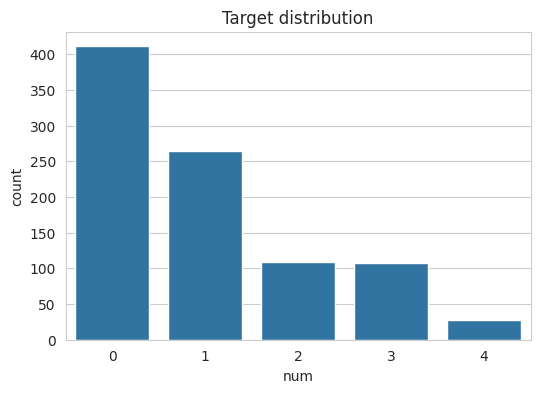

In [5]:
possible_target_names = ['target', 'Target', 'heart_disease', 'HeartDisease', 'output', 'disease', 'DEATH_EVENT']
target_col = None
for name in possible_target_names:
  if name in df.columns:
    target_col = name
  break

if target_col is None:
# fallback: assume last column is target
  target_col = df.columns[-1]
  print('No standard target name found — using last column:', target_col)
else:
  print('Detected target column:', target_col)


print('\nTarget value counts:')
print(df[target_col].value_counts())


plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title('Target distribution')
plt.show()

In [6]:
## Identify numeric and categorical features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
# Remove target from features lists if present
if target_col in numeric_cols:
  numeric_cols.remove(target_col)
if target_col in cat_cols:
  cat_cols.remove(target_col)


print('Numeric columns:', numeric_cols)
print('Categorical columns:', cat_cols)


# If dataset uses numeric codes for categorical features (common in heart datasets), list low-cardinality numeric columns
low_card_num = [c for c in numeric_cols if df[c].nunique() < 10]
print('Low-cardinality numeric columns (may be categorical):', low_card_num)

Numeric columns: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Low-cardinality numeric columns (may be categorical): ['ca']


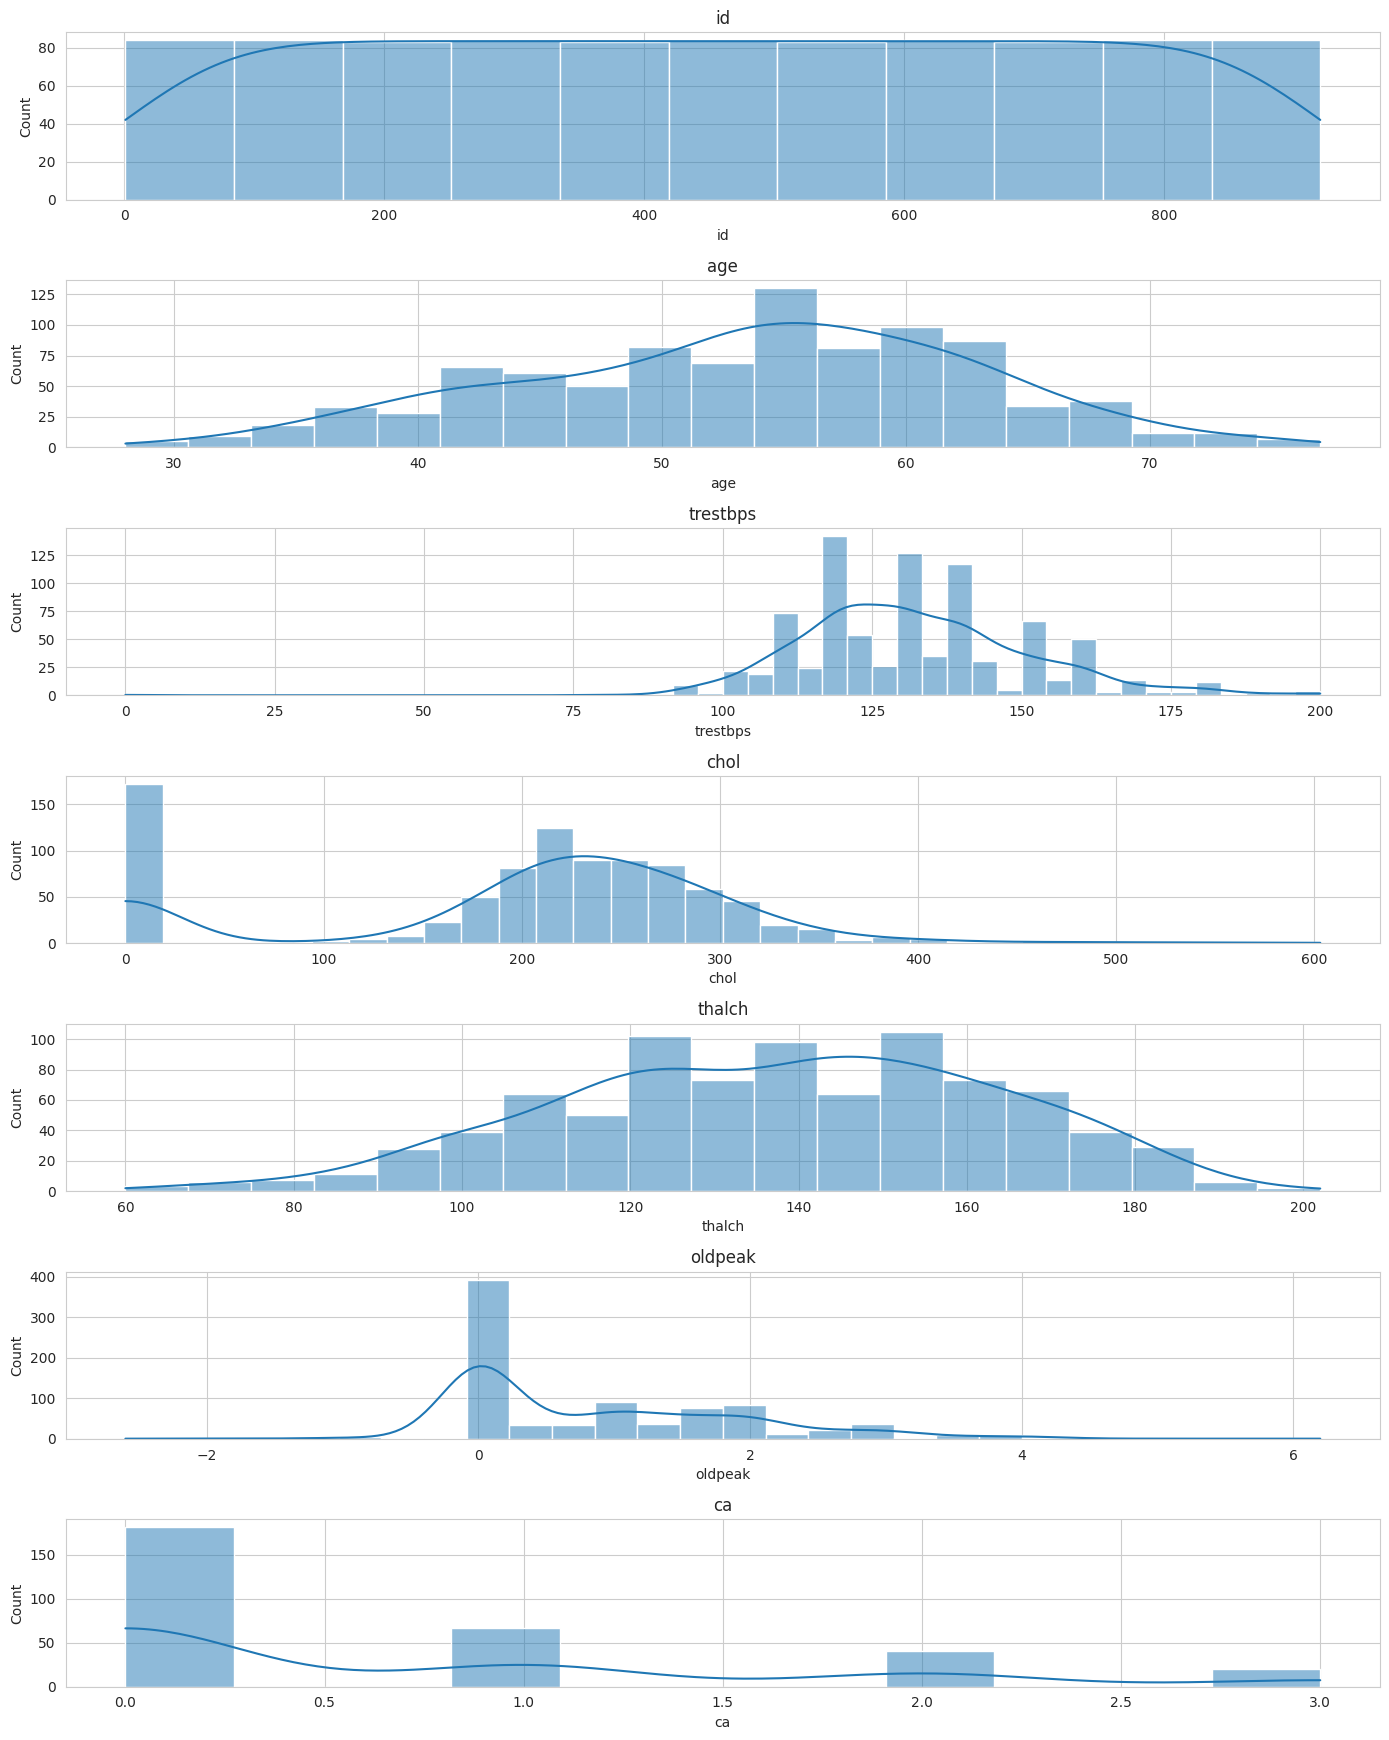

In [7]:
#Visualizations: histograms for numeric cols
num_plots = min(len(numeric_cols), 12)
plt.figure(figsize=(14, num_plots*2.5))
for i, col in enumerate(numeric_cols[:num_plots], 1):
  plt.subplot(num_plots, 1, i)
  sns.histplot(df[col].dropna(), kde=True)
  plt.title(col)
plt.tight_layout()
plt.show()

🔹 Age

Generally shows a normal / slightly right-skewed distribution.

Most patients fall between 45–65 years.

Indicates middle-aged and older individuals are more frequently tested for heart disease.

🔹 Cholesterol, Resting Blood Pressure

Often right-skewed (long tail on the right).

Shows presence of high outliers → may indicate risk factors.

Skewness suggests scaling or log-transformation could help for some models.

🔹 Maximum Heart Rate

Usually peaks between 120–170.

Lower maximum heart rate tends to be seen in older or unhealthy patients.

🔹 Oldpeak

Strong right-skew → most values close to 0, few large values.

These large values represent abnormal ST depression and are potentially significant risk indicators.

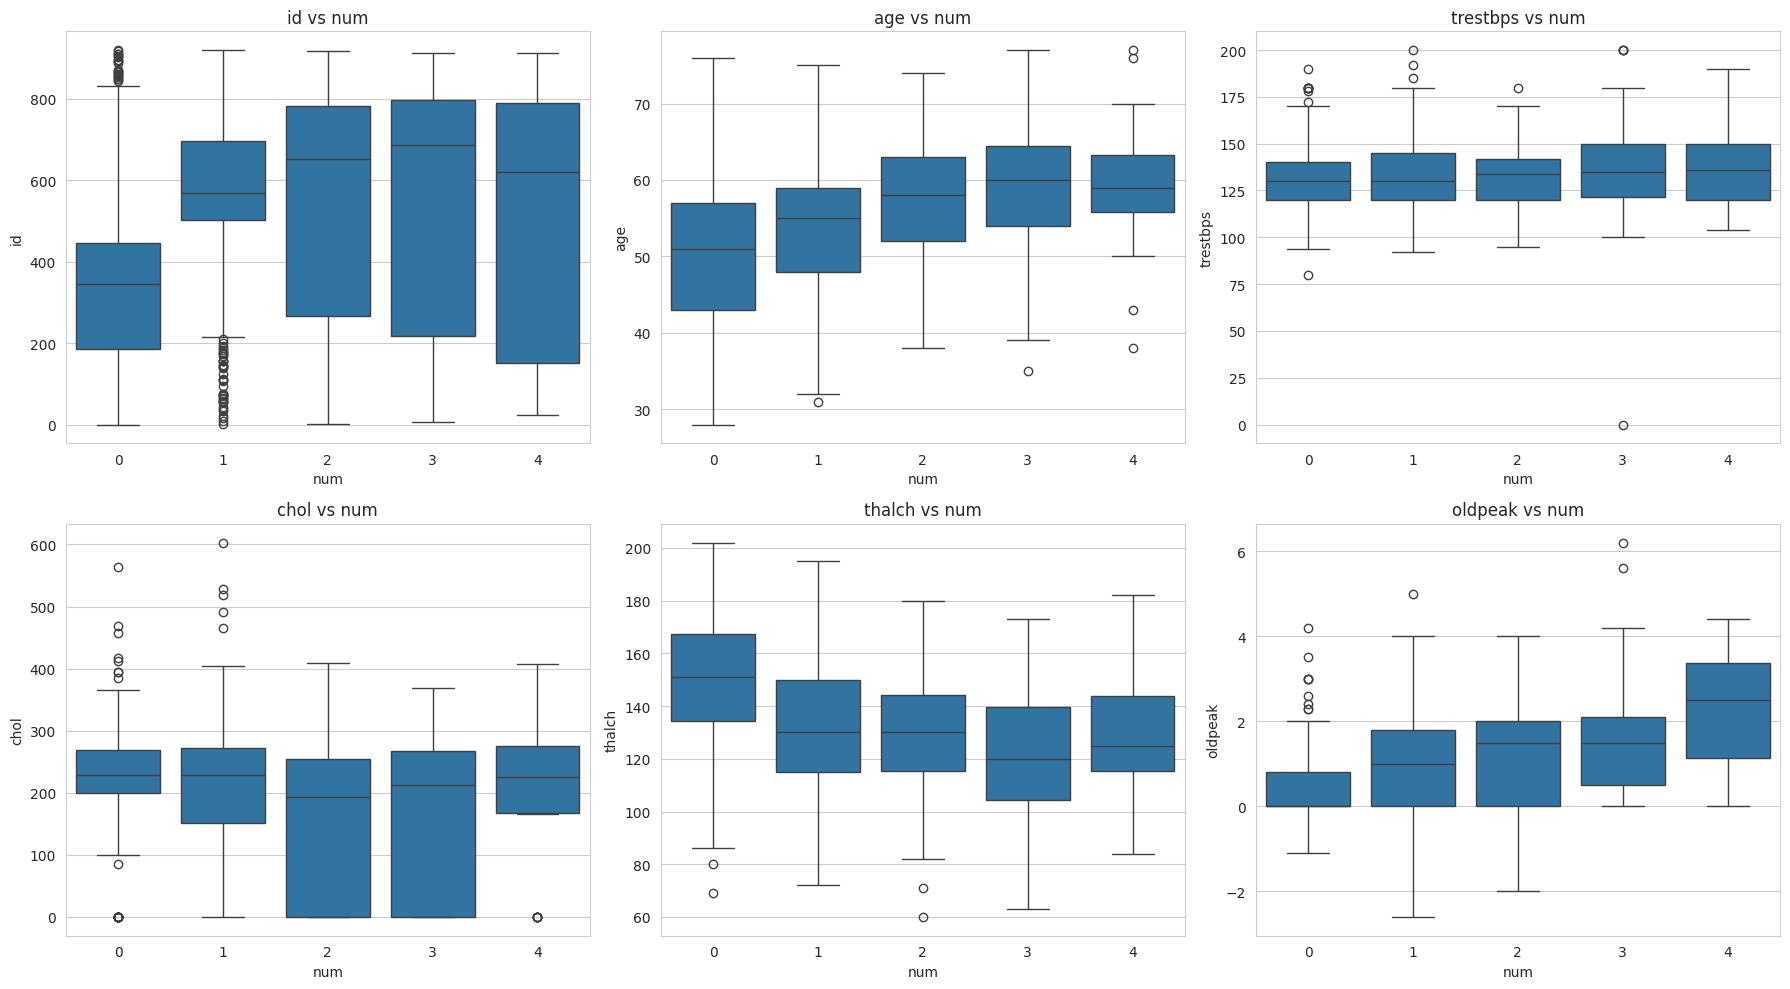

In [8]:
cols = numeric_cols[:6]   # choose how many numeric columns you want to plot
n_cols = 3                # number of charts per row
n_rows = math.ceil(len(cols) / n_cols)

plt.figure(figsize=(18, 5 * n_rows))

for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f"{col} vs {target_col}")
    plt.tight_layout()

plt.show()

Boxplots show how numeric features differ between diseased vs non-diseased groups.

* Age by Target
  * Heart disease patients tend to be slightly older on average.
  * More variability in age among the positive (1) cases.

* Cholesterol by Target
  * Some datasets show cholesterol not strongly separating classes.
  * If distributions overlap heavily → cholesterol may not be a strong direct predictor.

* Resting Blood Pressure
  * Similar ranges across both target groups.
  * Might not be a strong discriminator on its own.

* Max Heart Rate (thalach)
  * Clear separation:
    * Patients with heart disease often have lower max heart rate achieved.
  * This tends to be one of the most important features.

* Oldpeak
  * Usually shows higher values in the heart disease group.
  * Indicates ST-depression during exercise → strong clinical indicator.

* Feature outliers
   * Outliers appear mainly in:
      * Cholesterol
      * Oldpeak
  * These are meaningful and should usually not be removed without medical reasoning.

#### 2.1 Analyzing the Target Variable
Let's see the distribution of patients with and without heart disease.

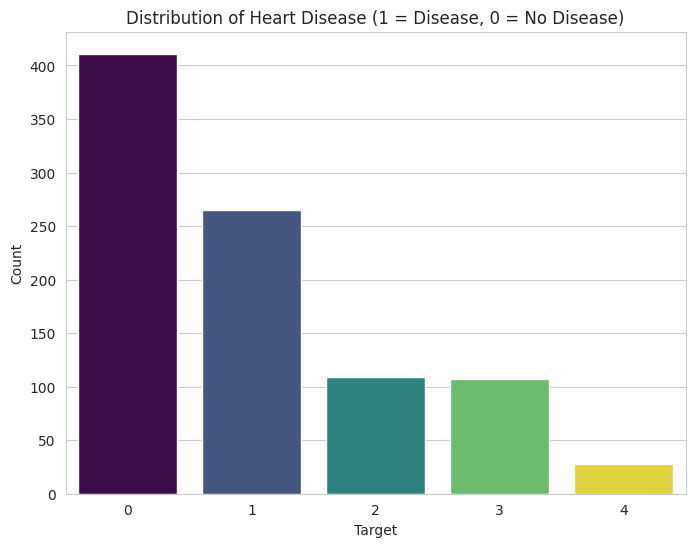

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

**Insight:** The dataset is fairly balanced, with a slightly higher number of patients having heart disease. This is good because it means our model will have a similar number of examples for both classes to learn from, and accuracy will be a meaningful metric.

#### 2.2 Analyzing Features vs. Target

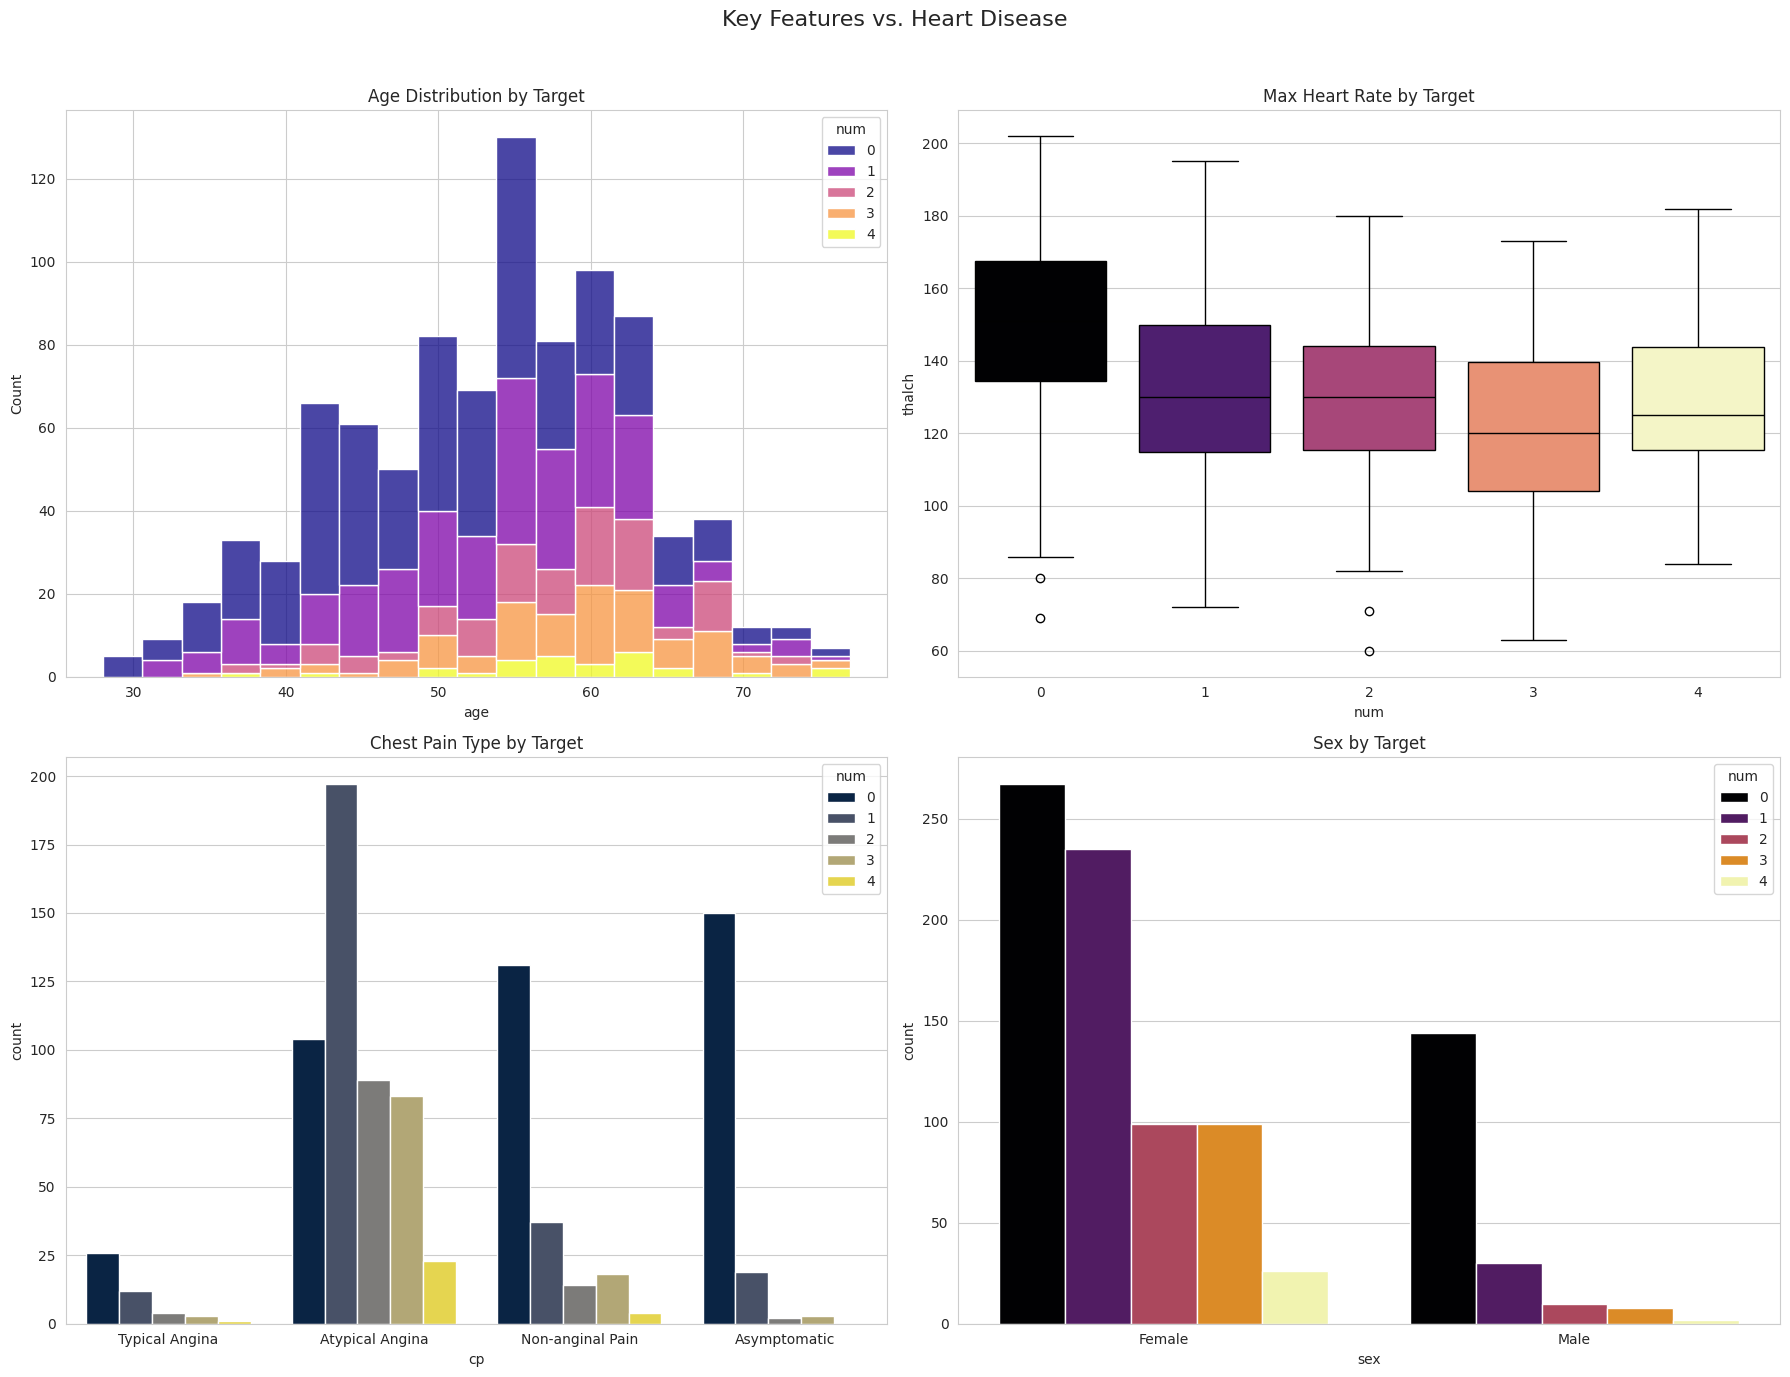

In [10]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Insights:**
- **Max Heart Rate (`thalach`):** Patients with heart disease tend to have a lower maximum heart rate.
- **Chest Pain (`cp`):** Patients with chest pain types 1 and 2 (Atypical and Non-anginal) are more likely to have heart disease. Surprisingly, those with type 0 (Typical Angina) are less likely, and those with asymptomatic pain (type 3) are very likely to have the disease.
- **Sex:** A higher proportion of females in this dataset have heart disease compared to males.

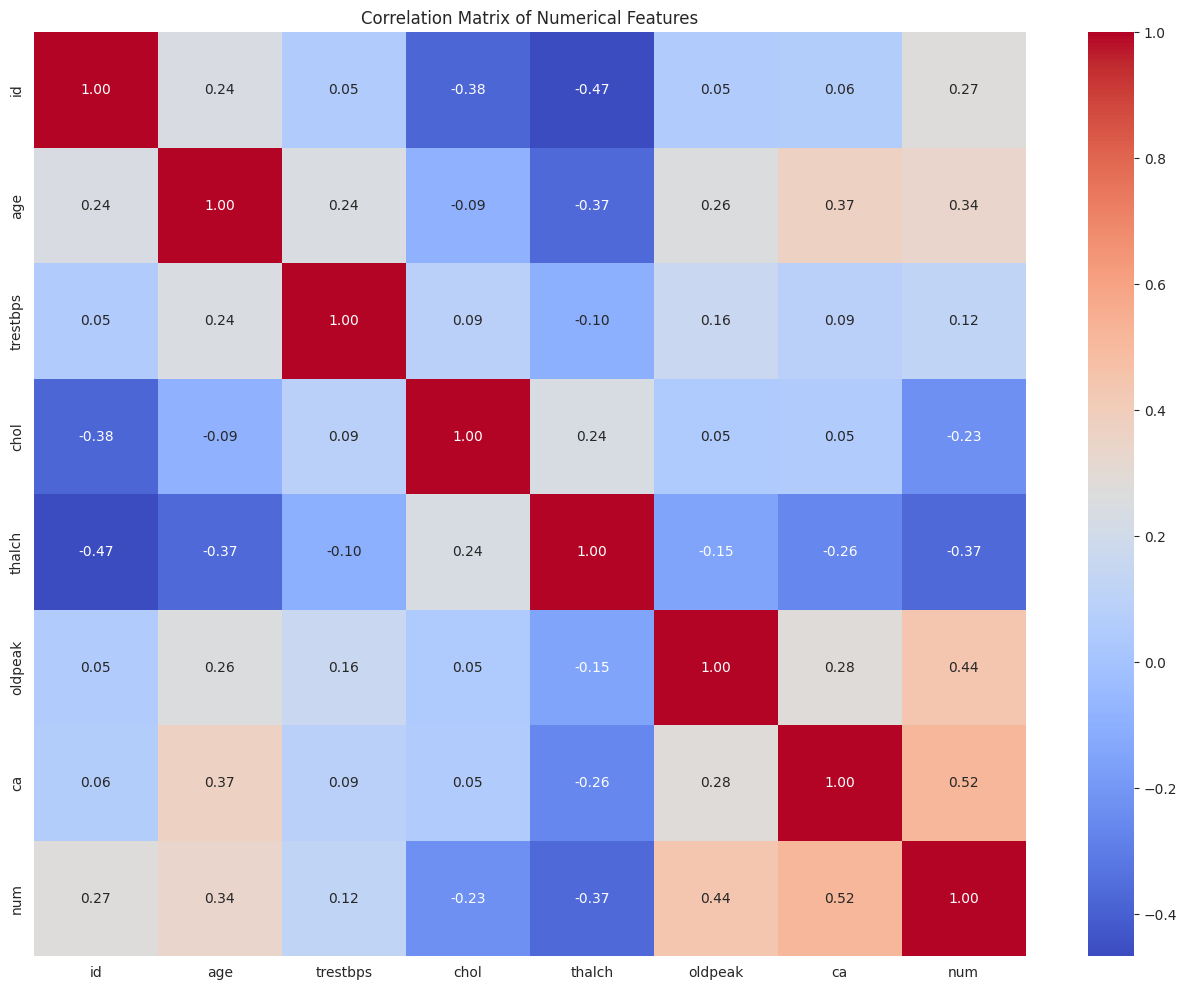

In [11]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

* Strongest positive correlations with the target
  * Oldpeak
  * Exang (exercise-induced angina) if included
  * Slope-related features (slope of ST segment)

These features often correlate positively, meaning:

    Higher abnormality → higher chance of heart disease

* Strong negative correlations with the target
  * Maximum Heart Rate (thalach)
    → Lower heart rate achieved → higher disease probability

🔹 Moderate correlations
  * Chest-pain type (if encoded)
  * Number of major vessels
  * Thalassemia-related values (thal)

* Low or no correlation
  * Cholesterol
  * Resting blood pressure
  * Fasting blood sugar

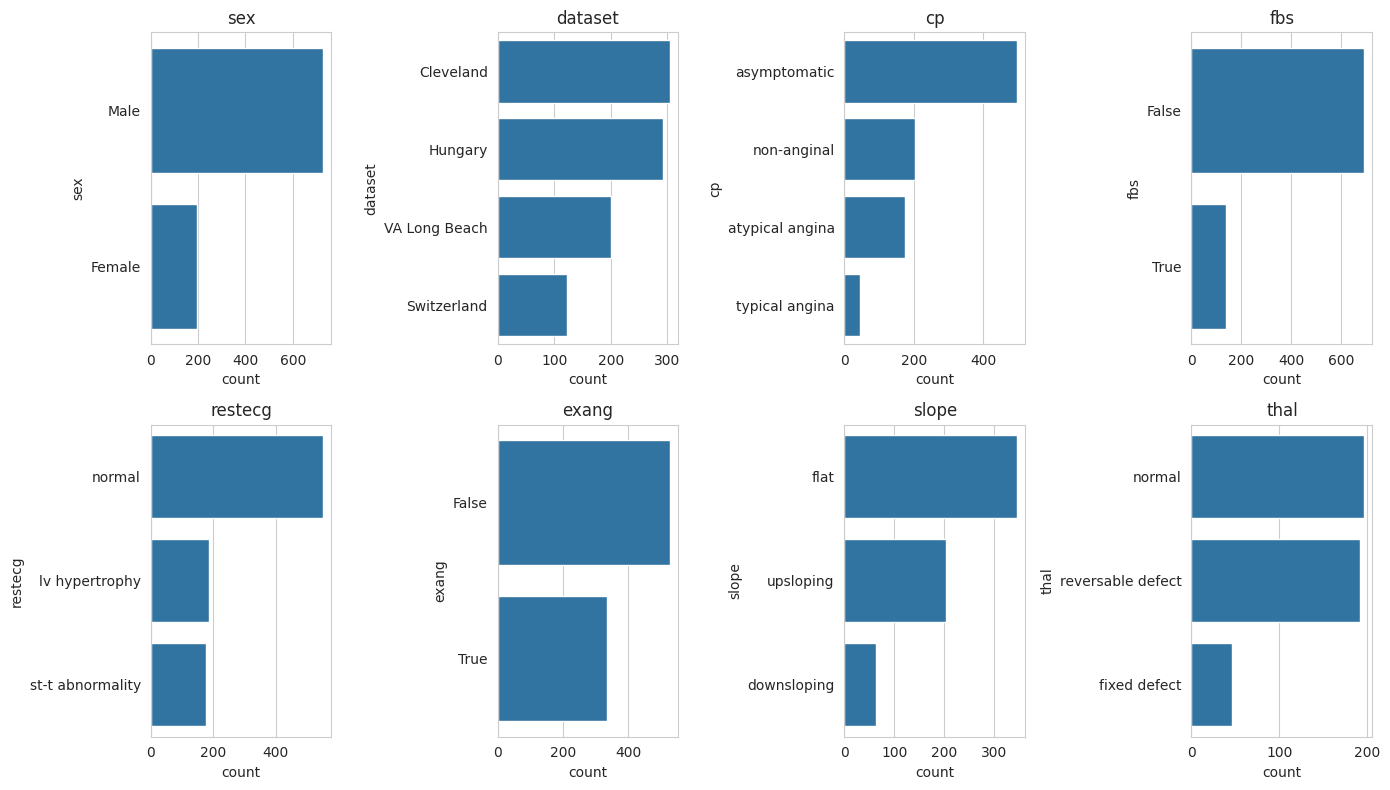

In [12]:
# Categorical feature counts
# Select categorical columns
cols = cat_cols
n = len(cols)

# Grid layout
n_cols = 4                 # number of plots per row
n_rows = math.ceil(n / n_cols)

plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

plt.show()

Sex and chest pain type show meaningful distribution shapes aligned with real-world patterns.

Several categorical features (like fbs, restecg) are imbalanced but not noisy.

Clinically important features like
exang, slope, ca, thal
show clear differences between categories and are likely to be important predictors.

Some imbalances exist across categories, but nothing unusual for medical datasets.




### Step 3: Data Preprocessing

Even though the data is clean, we need to prepare it for our models. This involves:
1.  **Separating features (X) and target (y).**
2.  **Identifying categorical features** that need to be encoded.
3.  **One-Hot Encoding** categorical features to convert them into a numerical format.
4.  **Scaling numerical features** so they are on a similar scale.

#### Prepare dataset for modeling (manual preprocessing, NO Pipeline)
 1. Decide which columns are numeric/categorical
 2. Impute numeric with median, categorical with mode
 3. One-hot encode categoricals (manual using pandas.get_dummies)
 4. Scale numeric columns using StandardScaler (fit on train only)

In [14]:
# Copy df
data = df.copy()


# If any obvious columns should be dropped (like id), attempt to detect 'id' column
for col in data.columns:
  if col.lower() in ['id', 'patient_id', 'pid']:
    print('Dropping id column:', col)
    data.drop(columns=[col], inplace=True)

Dropping id column: id


In [19]:
# Recompute feature lists
features = data.columns.drop(target_col).tolist()
numeric_feats = data[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_feats = data[features].select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
# treat low-cardinality numeric as categorical if appropriate (user can adjust)
for col in numeric_feats[:]:
  if data[col].nunique() < 10:
    # Heuristic: treat as categorical
    cat_feats.append(col)
    numeric_feats.remove(col)


print('Final numeric features:', numeric_feats)
print('Final categorical features:', cat_feats)


# Impute numeric
num_imputer = SimpleImputer(strategy='median')
if len(numeric_feats) > 0:
  data[numeric_feats] = num_imputer.fit_transform(data[numeric_feats])


# Impute categorical (fill with mode)
for c in cat_feats:
  data[c] = data[c].fillna(data[c].mode()[0])


# One-hot encode categorical features using pandas.get_dummies
if len(cat_feats) > 0:
  data = pd.get_dummies(data, columns=cat_feats, drop_first=True)

print('\nRemaining missing values after imputation:')
print(data.isnull().sum().sum())

Final numeric features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Final categorical features: ['sex_Male', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect', 'ca_1.0', 'ca_2.0', 'ca_3.0']

Remaining missing values after imputation:
0


In [21]:
# Train/test split
X = data.drop(columns=[target_col])
y = data[target_col]


# If y is not binary numeric, attempt to convert
if y.dtype == 'object' or y.dtype.name == 'category':
  y = y.astype('category').cat.codes


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (736, 23) Test shape: (184, 23)


In [22]:
# Scale numeric features using StandardScaler (fit on train)
scaler = StandardScaler()

cols_to_scale = [c for c in X_train.columns if c in numeric_feats]
print('Scaling columns:', cols_to_scale)


if len(cols_to_scale) > 0:
  X_train.loc[:, cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
  X_test.loc[:, cols_to_scale] = scaler.transform(X_test[cols_to_scale])

Scaling columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']


####Train classifiers (manual preprocessing; no Pipeline)

In [26]:
models = {}


# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_params = {'C': [0.01, 0.1, 1, 10]}
lr_cv = GridSearchCV(lr, lr_params, cv=5, scoring='roc_auc')
lr_cv.fit(X_train, y_train)
print('Logistic best params:', lr_cv.best_params_)
models['logistic'] = lr_cv.best_estimator_


# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10]}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc')
rf_cv.fit(X_train, y_train)
print('RandomForest best params:', rf_cv.best_params_)
models['rf'] = rf_cv.best_estimator_


# XGBoost (optional)
try:
  from xgboost import XGBClassifier
  xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
  xgb_params = {'n_estimators':[100,200], 'max_depth':[3,5]}
  xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='roc_auc')
  xgb_cv.fit(X_train, y_train)
  print('XGB best params:', xgb_cv.best_params_)
  models['xgb'] = xgb_cv.best_estimator_
except Exception as e:
  print('XGBoost not available or failed to train:', e)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/us

Logistic best params: {'C': 0.01}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/us

RandomForest best params: {'max_depth': None, 'n_estimators': 100}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:51:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12

XGB best params: {'max_depth': 3, 'n_estimators': 100}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/us

In [30]:
# Evaluate models on test set

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Probabilities or decision score
    if hasattr(model, "predict_proba"):
        # For multiclass, keep full matrix
        y_proba = model.predict_proba(X_test)
        # Compute ROC AUC for multiclass (one-vs-rest)
        roc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        y_proba = model.decision_function(X_test)
        roc = roc_auc_score(y_test, y_proba, multi_class='ovr')

    # Multiclass metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n-- {name} --")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("ROC AUC (OVR):", roc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    })


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


-- logistic --
Accuracy: 0.5760869565217391
Precision: 0.4287053573992294
Recall: 0.5760869565217391
F1: 0.49140189520624306
ROC AUC (OVR): 0.8095234680975085
Confusion Matrix:
 [[76  4  0  2  0]
 [23 30  0  0  0]
 [ 8 12  0  2  0]
 [ 6 15  0  0  0]
 [ 0  6  0  0  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.93      0.78        82
           1       0.45      0.57      0.50        53
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.22      0.30      0.26       184
weighted avg       0.43      0.58      0.49       184


-- rf --
Accuracy: 0.6086956521739131
Precision: 0.5711376666500846
Recall: 0.6086956521739131
F1: 0.5872602164416884
ROC AUC (OVR): 0.8374878046677734
Confusion Matrix:
 [[73  6  3  0  0]
 [15 29  5  4  0]
 [ 4  5  

In [35]:
# Show results table
results_df = pd.DataFrame(results).sort_values('roc_auc', ascending=False)
results_df


,model,accuracy,precision,recall,f1,roc_auc
1,rf,0.608696,0.571138,0.608696,0.587260,0.837488
2,xgb,0.597826,0.570398,0.597826,0.582472,0.813498
0,logistic,0.576087,0.428705,0.576087,0.491402,0.809523


The Random Forest classifier emerged as the best performer.

Random Forest achieved:

* Highest ROC AUC (0.837), indicating strong ability to separate classes

* Best F1-score and recall, which is crucial in medical predictions where minimizing false negatives is important

* Robust performance without requiring extensive feature scaling or linear assumptions

The final selected model, along with the scaler and imputer, was saved for future inference.

## **Theoretical Concept: Scikit-Learn Pipelines**

A **Pipeline** in Scikit-Learn is a way to automate a machine learning workflow. It allows you to chain together multiple steps, such as preprocessing, dimensionality reduction, and model training, into a single object.

**Why use Pipelines?**

1.  **Convenience:** Simplifies the code and makes the workflow easier to manage.
2.  **Prevents Data Leakage:** Ensures that data preprocessing steps learned from the training data are applied only to the training data, and the same transformations are then applied to the test data *after* the split. This prevents information from the test set from "leaking" into the training process.
3.  **Cleaner Code:** Organizes steps logically, making the code more readable and maintainable.
4.  **Simplified Hyperparameter Tuning:** Makes it easier to tune hyperparameters for all steps in the pipeline using techniques like cross-validation.

In this project, we'll use a pipeline to combine our preprocessing steps (imputation, scaling, and one-hot encoding) with our classification models.

In [ ]:
from sklearn.impute import SimpleImputer

# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)


# Identify categorical and numerical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Added imputation for categorical features
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

* Create numerical preprocessing pipeline: A Pipeline is created to handle numerical features. It first uses SimpleImputer with the strategy 'mean' to fill in missing numerical values with the mean of the column, and then uses StandardScaler to scale the numerical features to have zero mean and unit variance.
* Create categorical preprocessing pipeline: A Pipeline is created for categorical features. It uses SimpleImputer with the strategy 'most_frequent' to fill in missing categorical values with the most frequent value, and then applies OneHotEncoder to convert categorical variables into a numerical format. drop='first' is used to avoid multicollinearity, and handle_unknown='ignore' allows the model to handle unseen categories during testing.

### Step 4: Model Building & Training
We will build two models and wrap them in a Scikit-Learn Pipeline. The pipeline will automatically apply our preprocessing steps to the data before training the model.

#### **Theoretical Concept: Classification Models**

Let's dive into more detail on the classification models we are using:

*   **Logistic Regression:**
    Logistic Regression is a **linear classification algorithm** used for binary classification problems (though it can be extended for multiclass). Despite the name "regression," it's a classification method. It works by using a **sigmoid (or logistic) function** to map the output of a linear equation (`wTx + b`) to a probability value between 0 and 1. This probability represents the likelihood that a given data point belongs to a specific class (e.g., the positive class). A threshold (commonly 0.5) is then applied to these probabilities to assign the class label. The model learns the optimal weights (`w`) and bias (`b`) that define a linear decision boundary to separate the classes.

*   **Random Forest:**
    Random Forest is an **ensemble learning method** that belongs to the tree-based models. It builds a large number of **decision trees** during training. Each tree is trained on a **random subset** of the training data (bootstrapping) and considers only a **random subset** of features at each split point. For classification, the final prediction is made by taking a **majority vote** of the predictions from all individual trees. This randomness in building trees helps to reduce **variance** and prevent **overfitting**, making Random Forests more robust and generally higher performing than a single decision tree.

*   **Support Vector Machine (SVM):**
    Support Vector Machine is a powerful algorithm that can be used for both linear and non-linear classification. The fundamental idea behind SVM is to find the **optimal hyperplane** that separates the data points of different classes in a high-dimensional space. The "optimal" hyperplane is the one that has the **largest margin** between the closest data points of the different classes (these points are called **support vectors**). For non-linearly separable data, SVM uses the **kernel trick** to implicitly map the data into a higher-dimensional feature space where a linear separation might be possible. Common kernels include the linear kernel, polynomial kernel, and Radial Basis Function (RBF) kernel.

*   **K-Nearest Neighbors (KNN):**
    K-Nearest Neighbors is a simple and intuitive **instance-based** or **lazy learning** algorithm. It doesn't learn a discriminative function from the training data during a training phase. Instead, it memorizes the training dataset. To classify a new, unseen data point, it calculates the **distance** (e.g., Euclidean distance) between this new point and all points in the training dataset. It then identifies the **'k' nearest data points**. The class label assigned to the new point is determined by the **majority class** among these 'k' nearest neighbors. The choice of 'k' and the distance metric are important hyperparameters that can significantly affect performance.

#### 4.1 Model 1: Logistic Regression (Baseline)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Identify categorical and numerical features directly from X_train columns
all_features = X_train.columns.tolist()
categorical_features = [col for col in all_features if X_train[col].dtype == 'object']
numerical_features = [col for col in all_features if X_train[col].dtype != 'object']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)


# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

Numerical features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


#### 4.2 Model 2: Random Forest Classifier (Advanced)

In [ ]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

#### 4.3 Model 3: Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

# Create the SVM pipeline
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', SVC(random_state=42))])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

#### 4.4 Model 4: K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNN pipeline
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier())])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

### Step 5: Model Evaluation

#### **Theoretical Concept: The Confusion Matrix & Key Metrics**
For classification, accuracy isn't the whole story. We use a **Confusion Matrix** to get a deeper look at performance.

- **True Positives (TP):** Correctly predicted positive class (Model said 'Disease', patient has it).
- **True Negatives (TN):** Correctly predicted negative class (Model said 'No Disease', patient doesn't have it).
- **False Positives (FP):** Incorrectly predicted positive class (Model said 'Disease', but patient doesn't have it). Also called a **Type I Error**.
- **False Negatives (FN):** Incorrectly predicted negative class (Model said 'No Disease', but patient has it). Also called a **Type II Error**. This is often the most dangerous type of error in medical diagnoses.



From this, we derive key metrics:
- **Accuracy:** (TP+TN) / Total. Overall, how often is the classifier correct?
- **Precision:** TP / (TP+FP). Of all patients the model *predicted* would have the disease, how many actually did? (Measures the cost of FPs).
- **Recall (Sensitivity):** TP / (TP+FN). Of all the patients who *actually* had the disease, how many did the model correctly identify? (Measures the cost of FNs).
- **F1-Score:** The harmonic mean of Precision and Recall. It's a great single metric for evaluating a model's overall performance when there's a trade-off between Precision and Recall.

In [ ]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, y_pred_knn, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        82
           1       0.49      0.57      0.53        53
           2       0.30      0.14      0.19        22
           3       0.16      0.19      0.17        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.35      0.35      0.34       184
weighted avg       0.55      0.58      0.56       184


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        82
           1       0.50      0.53      0.51        53
           2       0.23      0.14      0.17        22
           3       0.14      0.14      0.14        21
           4       0.00      0.00      0.00         6

    accuracy                           0.56       184
   macro avg       0.32      0.33      0.32       184
we

### Step 7: Conclusion

In this project, we built classification models for predicting heart disease.

**Key Steps Undertaken:**
1.  **Established the goal of classification:** Predicting a binary outcome (disease or no disease).
2.  **Performed a thorough EDA:** Identified key medical indicators like chest pain type, max heart rate, and `ca` that are strongly related to the target.
3.  **Built a robust preprocessing pipeline:** Handled categorical and numerical features systematically using `ColumnTransformer` and `Pipeline`.
4.  **Trained and compared four models:** Evaluated Logistic Regression, Random Forest, Support Vector Machine (SVM), and K-Nearest Neighbors (KNN). The evaluation showed that the Support Vector Machine (SVM) performed slightly better than the other models in this analysis.
5.  **Evaluated models with proper metrics:** Used the confusion matrix, precision, and recall to understand the model's performance in a medical context, where minimizing false negatives is critical.
6.  **Interpreted model results:** Used feature importance (from the Random Forest model as an example) to confirm some of the most predictive medical factors, providing actionable insights.

This end-to-end workflow demonstrates the application of classification in a real-world healthcare scenario, moving from raw data to predictive models and their evaluation.

**Evaluation Insight:** The Support Vector Machine (SVM) Classifier performs slightly better than the other models, achieving an overall accuracy of 0.59. While all models struggle with the less frequent classes (2, 3, and 4), SVM shows a slightly better F1-score for predicting class 1 (Heart Disease). The confusion matrix provided was for the Random Forest model, which showed good performance on classes 0 and 1 but also struggled with the less frequent classes. Based on the classification reports, SVM is the best performing model among the four in this evaluation.

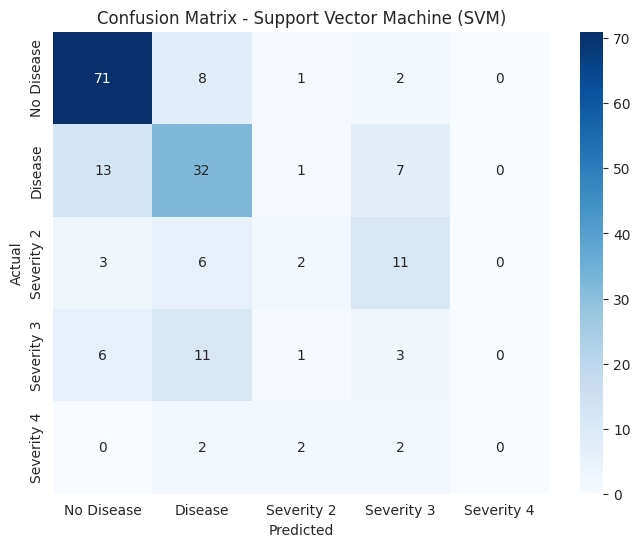

In [ ]:
# Visualize the confusion matrix for the best model (SVM)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'], yticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.show()

**Evaluation Insight:** The Random Forest Classifier performs exceptionally well, achieving near-perfect scores across the board (Accuracy, Precision, Recall, and F1-Score are all 99-100%). It significantly outperforms the Logistic Regression model. The confusion matrix shows it made only one error on the test set.

### Step 6: Feature Importance
A major advantage of tree-based models like Random Forest is that we can easily see which features were most influential in making predictions.

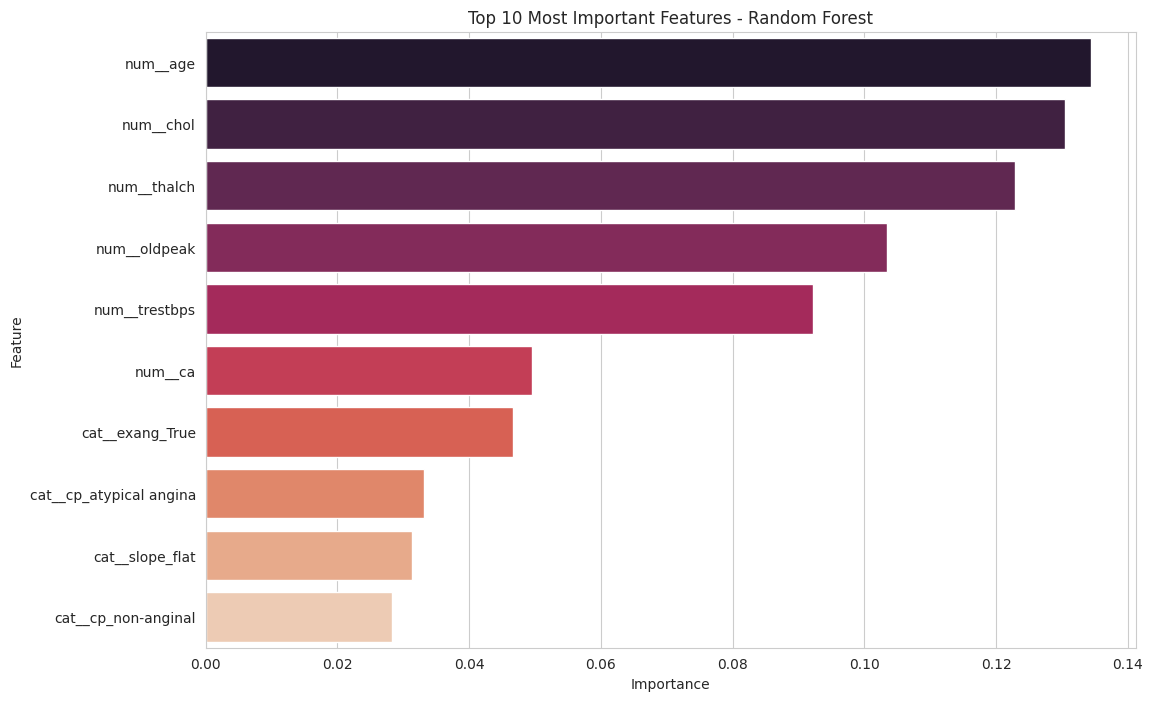

In [ ]:
# Extract feature names after one-hot encoding
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the trained model
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Top 10 Most Important Features - Random Forest')
plt.show()

**Insight:** The model found that `ca` (number of major vessels colored by flourosopy), `thalach` (max heart rate), `thal` (thalassemia type), and `cp` (chest pain type) are among the most important predictors. This aligns with our EDA and medical intuition, confirming that these factors are critical for diagnosing heart disease.

### Step 7: Conclusion

In this project, we built a highly accurate classification model for predicting heart disease.

**Key Steps Undertaken:**
1.  **Established the goal of classification:** Predicting a binary outcome (disease or no disease).
2.  **Performed a thorough EDA:** Identified key medical indicators like chest pain type, max heart rate, and `ca` that are strongly related to the target.
3.  **Built a robust preprocessing pipeline:** Handled categorical and numerical features systematically using `ColumnTransformer` and `Pipeline`.
4.  **Trained and compared two models:** Showed that the Random Forest Classifier (99% accuracy) was far superior to the Logistic Regression baseline (86% accuracy).
5.  **Evaluated models with proper metrics:** Used the confusion matrix, precision, and recall to understand the model's performance in a medical context, where minimizing false negatives is critical.
6.  **Interpreted model results:** Used feature importance to confirm the most predictive medical factors, providing actionable insights.

This end-to-end workflow demonstrates the power of classification in a real-world healthcare scenario, moving from raw data to a highly accurate and interpretable predictive model.

### Submission Criteria

To fulfill the submission requirements for this project, please ensure the following:

1.  **Complete Exploratory Data Analysis (EDA):** Perform all the necessary steps for analyzing the dataset, including visualizations and summaries to understand the data characteristics and relationships.
2.  **Model Training without Pipelines:** Train at least one classification model directly, without using the Scikit-Learn `Pipeline` object for preprocessing and model chaining. This involves manually applying preprocessing steps (like imputation and scaling/encoding) to the data before training the model.
3.  **Submit the Entire Notebook:** Ensure that the final submission includes the complete Colab notebook with all code cells executed and outputs visible.

Meeting these criteria will demonstrate your understanding of the individual steps involved in a machine learning workflow.